### Computing the camera calibration matrix and distortion coefficients (given a set of chessboard images) 

In [1]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.rcParams["axes.grid"] = False

In [2]:
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')


# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
      
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)


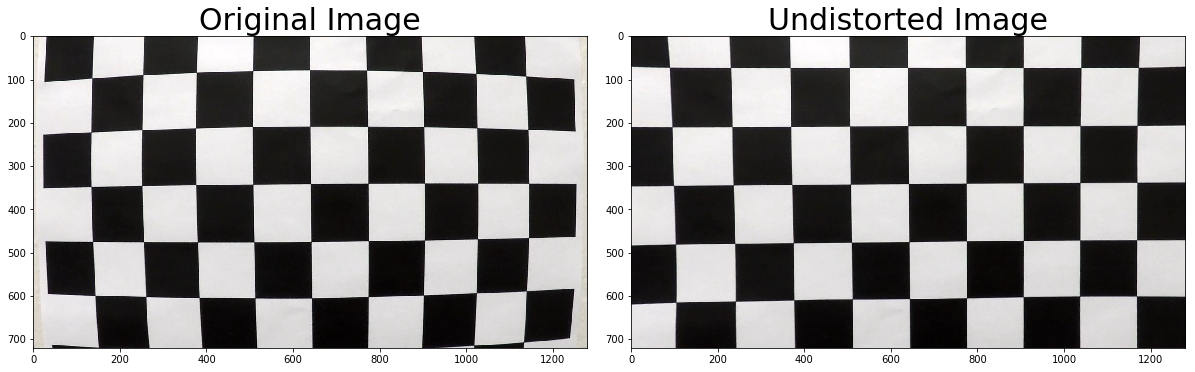

In [3]:
# Example
img = mpimg.imread('camera_cal/calibration1.jpg')
undist = cv2.undistort(img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Applying a distortion correction

In [4]:
img = mpimg.imread('test_images/test1.jpg')
undist = cv2.undistort(img, mtx, dist, None, mtx)

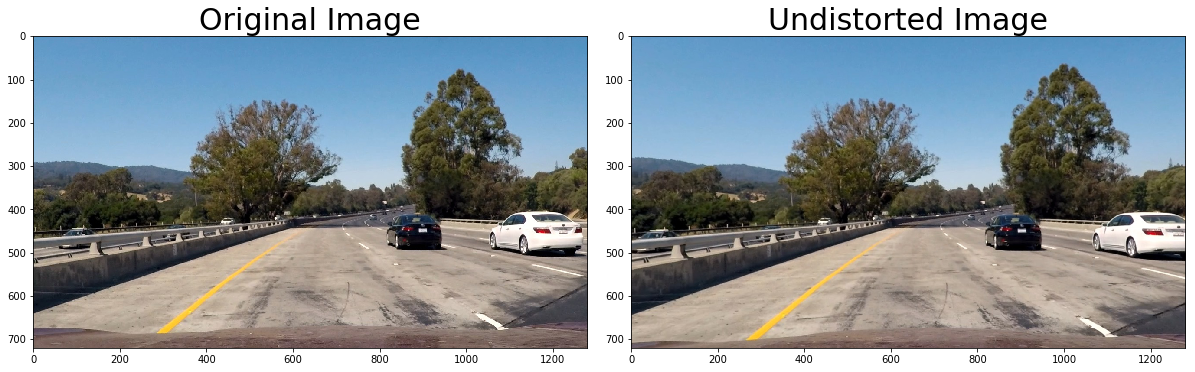

In [5]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Using color transform and gradients to create a thresholded binary image

In [6]:
def thresholded_binary_image(img, l_thresh=(215, 255) , lab_thresh=(145,200) , b_thresh=(215, 255)):
  
  
  # Threshold color channel to detect white lanes 
  # Convert to HLS color space 
  hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
  l_channel = hls[:,:,1]
  
  l_binary = np.zeros_like(l_channel)
  l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1

  # Threshold color channel to detect yellow lanes 
  # Convert to LAB color space 
  lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
  lab_b = lab[:,:,2]
  
  lab_binary = np.zeros_like(lab_b)
  lab_binary[(lab_b > lab_thresh[0]) & (lab_b <= lab_thresh[1])] = 1
  
  # B color channel
  B_channel = img[:,:,0]
  B_binary = np.zeros_like(B_channel)
  B_binary[(B_channel >= b_thresh[0]) & (B_channel <= b_thresh[1])] = 1
  
  R_binary = np.zeros_like(lab_binary)
  R_binary[(B_binary == 1) | (lab_binary == 1) ] = 1
  #make the thresholded binary image by combining Threshold x gradient and Threshold color channel

  color_binary = np.dstack(( np.zeros_like(R_binary), R_binary, l_binary)) * 255

  combined = np.zeros_like(l_binary)
  combined[(l_binary == 1) | (R_binary == 1) ] = 1
    
  return combined , color_binary

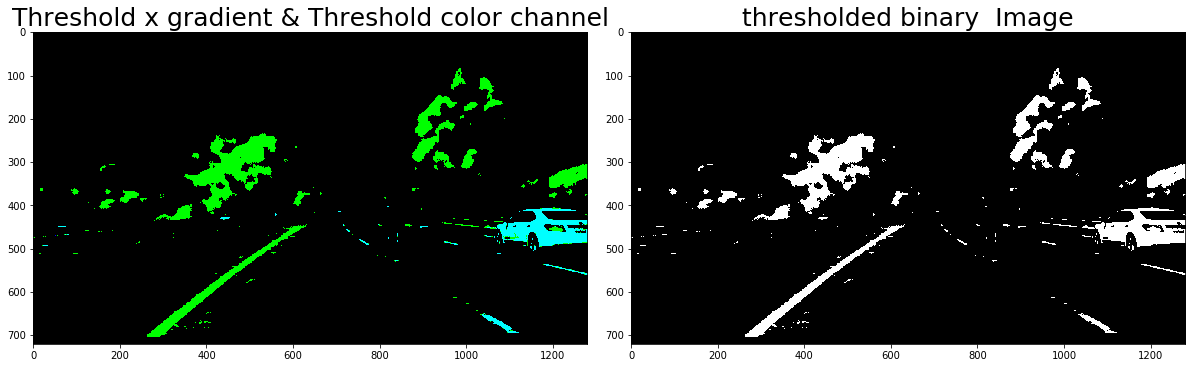

In [7]:
# Visualize Pipeline Result
combined , color_binary = thresholded_binary_image(undist)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
f.tight_layout()

ax1.imshow(color_binary)
ax1.set_title('Threshold x gradient & Threshold color channel', fontsize=25)

ax2.imshow(combined , cmap= 'gray')
ax2.set_title('thresholded binary  Image', fontsize=25)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Applying a perspective transform to rectify binary image ("birds-eye view") 

In [8]:
def birds_eye_view(combined):
  img_size = (1280, 720)
  # For source points I'm grabbing four points
  src = np.float32([[200,720],[579, 460],[706, 460],[1128,720]])
  # For destination points, I'm arbitrarily choosing some points to be a nice fit for displaying our warped result 
  dst = np.float32([[318,720],[318, 0],[961, 0],[961,720]])
        
  # Given src and dst points, calculate the perspective transform matrix
  M = cv2.getPerspectiveTransform(src, dst)
  # Warp the image using OpenCV warpPerspective()
  warped = cv2.warpPerspective(combined, M, img_size)
  return warped , src ,dst

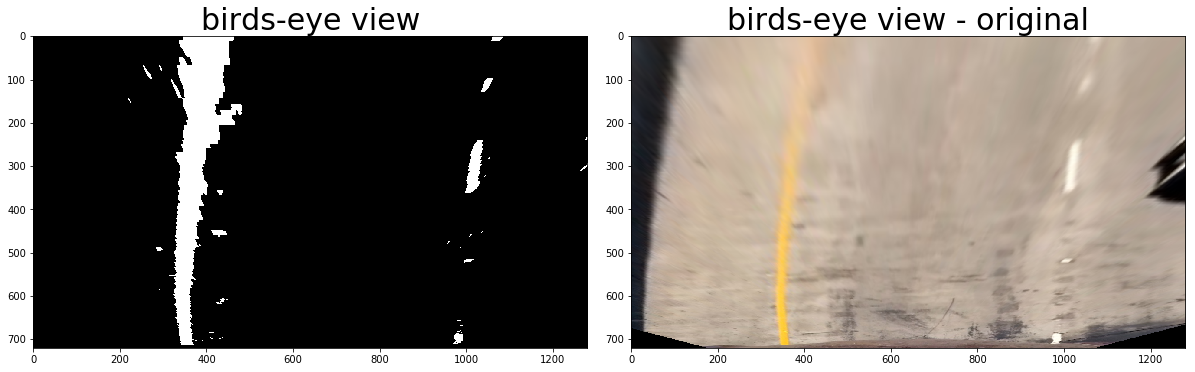

In [9]:
warped_undist , src ,dst = birds_eye_view(undist)
warped , src ,dst = birds_eye_view(combined)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
f.tight_layout()

ax1.imshow(warped , cmap= 'gray')
ax1.set_title('birds-eye view', fontsize=30)

ax2.imshow(warped_undist)
ax2.set_title('birds-eye view - original', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Detect lane pixels and fit to find the lane boundary

In [10]:
def search_scratch(warped):
  binary_warped = warped
  
    # Take a histogram of the bottom half of the image
  histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
  out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
  midpoint = np.int(histogram.shape[0]//2)
  leftx_base = np.argmax(histogram[:midpoint])
  rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
  nwindows = 9
    # Set the width of the windows +/- margin
  margin = 100
    # Set minimum number of pixels found to recenter window
  minpix = 50

    # Set height of windows - based on nwindows above and image shape
  window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
  nonzero = binary_warped.nonzero()
  nonzeroy = np.array(nonzero[0])
  nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
  leftx_current = leftx_base
  rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
  left_lane_inds = []
  right_lane_inds = []

    # Step through the windows one by one
  for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
      win_y_low = binary_warped.shape[0] - (window+1)*window_height
      win_y_high = binary_warped.shape[0] - window*window_height
      win_xleft_low = leftx_current - margin
      win_xleft_high = leftx_current + margin
      win_xright_low = rightx_current - margin
      win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
      cv2.rectangle(out_img,(win_xleft_low,win_y_low),
      (win_xleft_high,win_y_high),(0,255,0), 2) 
      cv2.rectangle(out_img,(win_xright_low,win_y_low),
      (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
      good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
      (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
      good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
      (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
      left_lane_inds.append(good_left_inds)
      right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
      if len(good_left_inds) > minpix:
          leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
      if len(good_right_inds) > minpix:        
          rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
  try:
      left_lane_inds = np.concatenate(left_lane_inds)
      right_lane_inds = np.concatenate(right_lane_inds)
  except ValueError:
        # Avoids an error if the above is not implemented fully
      pass

    # Extract left and right line pixel positions
  leftx = nonzerox[left_lane_inds]
  lefty = nonzeroy[left_lane_inds] 
  rightx = nonzerox[right_lane_inds]
  righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each using `np.polyfit`
  left_fit = np.polyfit(lefty, leftx, 2)
  right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
  ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
  try:
      left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
      right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
  except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
      left_fitx = 1*ploty**2 + 1*ploty
      right_fitx = 1*ploty**2 + 1*ploty
        
  out_img[lefty, leftx] = [255, 0, 0]
  out_img[righty, rightx] = [0, 0, 255]    
  return left_fitx , right_fitx , ploty, left_fit , right_fit , out_img

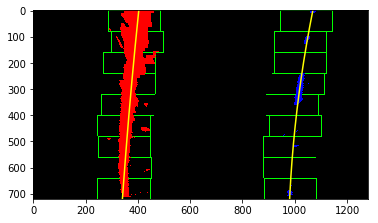

In [11]:
left_fitx , right_fitx , ploty, left_fit , right_fit , out_img = search_scratch(warped)
# Plots the left and right polynomials on the lane lines
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')   
plt.imshow(out_img) 

### Determine the curvature of the lane and vehicle position with respect to center 

In [12]:
def measure_curvature_real(left_fitx ,right_fitx ,ploty ,undist):
  
  '''
  Calculates the curvature of polynomial functions in meters.
  '''
  # conversions in x and y from pixels space to meters
  ym_per_pix = 30/720 # meters per pixel in y dimension
  xm_per_pix = 3.7/640 # meters per pixel in x dimension
    
  leftx = left_fitx
  rightx = right_fitx
  
  leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
  rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

  left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
  right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
  # Defining y-value where we want radius of curvature
  # We'll choose the maximum y-value, corresponding to the bottom of the image
  y_eval = np.max(ploty*ym_per_pix)
    
  #the calculation of R_curve (radius of curvature) and car position
  AL =left_fit_cr[0]
  BL = left_fit_cr[1]
  AR =right_fit_cr[0]
  BR = right_fit_cr[1]
  Y = y_eval
  left_curverad = ((1 + ((2*AL*Y) + BL)**2)**1.5) / np.absolute(2*AL)   ## Implement the calculation of the left line here
  right_curverad = ((1 + ((2*AR*Y) + BR)**2)**1.5) / np.absolute(2*AR)  ## Implement the calculation of the right line here
    
  car_center = undist.shape[1] / 2
  K = undist.shape[0]-1

  vehicle_position = (car_center - (right_fitx[K] + left_fitx[K])/2 )* xm_per_pix 

    
  return left_curverad, right_curverad  , vehicle_position

In [13]:
left_curverad, right_curverad , vehicle_position = measure_curvature_real(left_fitx ,right_fitx ,ploty ,undist)

print(left_curverad, 'm', right_curverad, 'm', vehicle_position , 'm')

6342.29722403 m 1411.45201443 m -0.120364579811 m


### Warp the detected lane boundaries back onto the original image.


In [14]:
### Warp the detected lane boundaries back onto the original image

def print_on_original(undist ,warped ,dst ,src ,left_fitx ,right_fitx ,ploty ,left_curverad ,right_curverad ,vehicle_position):
  # Create an image to draw the lines on
  warp_zero = np.zeros_like(warped).astype(np.uint8)
  color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
  Minv = cv2.getPerspectiveTransform(dst, src)
  

  # Recast the x and y points into usable format for cv2.fillPoly()
  pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
  pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
  pts = np.hstack((pts_left, pts_right))

  # Draw the lane onto the warped blank image
  if (vehicle_position > 0.3) | (vehicle_position < -0.3)  :
    cv2.fillPoly(color_warp, np.int_([pts]), (255,0, 0))
  else :
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 230))
    
  cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,255,0), thickness=20)
  cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(255,255,255), thickness=20)  
  # Warp the blank back to original image space using inverse perspective matrix (Minv)
  newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
  # Combine the result with the original image
  result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
  ### writting the curvature of the lane and vehicle position with respect to center   
  font = cv2.FONT_HERSHEY_SIMPLEX
  lc = str(int(left_curverad))
  rc = str(int(right_curverad))
  VP = str(vehicle_position)
  result = cv2.putText(result, 'Curvature: Left = ' + lc + ' ,  Right = ' + rc  , (30, 30), font, 0.8, (0, 255, 0), 2, cv2.LINE_AA) 
  result = cv2.putText(result, 'vehicle position with respect to center = ' + VP , (30, 60), font, 0.8, (0, 255, 0), 2, cv2.LINE_AA) 

  return result


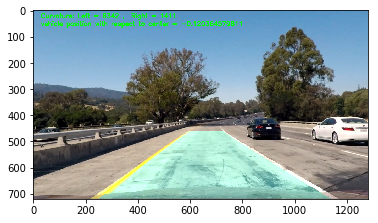

In [15]:
result = print_on_original(undist ,warped ,dst ,src ,left_fitx ,right_fitx ,ploty ,left_curverad ,right_curverad ,vehicle_position)
plt.imshow(result)

### All pipeline

In [16]:
def detection(img):

  ### applying a distortion correction
  
  undist = cv2.undistort(img, mtx, dist, None, mtx)
      
  ### Use color transforms, gradients, etc., to create a thresholded binary image
  
  combined , color_binary = thresholded_binary_image(undist)
        
  ### birds-eye view 
  
  warped ,src ,dst = birds_eye_view(combined)
   
  ### Detect lane pixels and fit to find the lane boundary 
  left_fitx , right_fitx , ploty, left_fit , right_fit , out_img = search_scratch(warped)
    
    
  ### Determine the curvature of the lane and vehicle position with respect to center 
  left_curverad, right_curverad , vehicle_position = measure_curvature_real(left_fitx , right_fitx , ploty ,undist)
  
  
  ### Warp the detected lane boundaries back onto the original image.
  result = print_on_original(undist ,warped ,dst ,src ,left_fitx ,right_fitx ,ploty ,left_curverad ,right_curverad ,vehicle_position)
   
  return result

### Testing Images

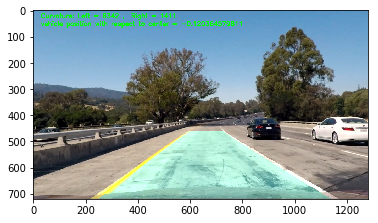

In [17]:
img = mpimg.imread('test_images/test1.jpg')

tt = detection(img)
plt.imshow(tt)

### Testing the video

In [18]:
!pip install moviepy
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [ ]:
white_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(detection) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


 19%|█▉        | 244/1261 [00:51<03:47,  4.47it/s]

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))